# <center> Clasificación binaria simple </center>

Uno de los mejores repositorios de bases de datos y conjuntos de datos para el estudio del *machine learning* es [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php), entre los recursos que alberga encontramos [Connectionist Bench (Sonar, Mines vs. Rocks) Data Set](https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)), esta base de datos pretende poder entrenar una red para distinguir entre las señales de sonar que rebotan en un cilindro de metal y las que rebotan en una roca aproximadamente cilíndrica para detectar cuando hay una mina.

En los archivos encontramos *sonar.mines* que contiene $111$ patrones obtenidos al hacer rebotar señales de sonar en un cilindro de metal en varios ángulos y bajo diversas condiciones, también el archivo "sonar.rocks" contiene $97$ patrones obtenidos de rocas en condiciones similares. La señal del sonar transmitida es un chirrido de frecuencia modulada, aumentando en frecuencia. El conjunto de datos contiene señales obtenidas desde una variedad de ángulos de aspecto diferentes, que abarcan $90°$ para el cilindro y $180°$ para la roca, teniendo un total de **208 datos** de los cuales **111 y 97** son datos de minas y rocas respectivamente.

Cada patrón es un conjunto de $60$ números en el rango de $0,0$ a $1,0$. Cada número representa la energía dentro de una banda de frecuencia particular, integrada durante un cierto período de tiempo. La apertura de integración para frecuencias más altas ocurre más tarde en el tiempo, ya que estas frecuencias se transmiten más tarde durante el chirrido. Estos $60$ datos correspondarán a nuestro vector de características, con lo cual la dimensión del espacio de características es $60$ y las etiqeutas dadas en este caso son **R** o **M** de haberse detectado una roca o una mina respectivamente.

En el presente documento usaremos el conjunto de datos mencionado, dividiremos los datos en entretamiento y prueba que usaremos en diferentes modelos de clasificación binaria, al final compararemos los resultados y analizaremos la precisión de cada uno de los modelos.

## 1 Importamos y observamos los datos

Empezamos cargando las librerias que usaremos a lo largo del documento:

In [1]:
using CSV: read # Para leer la base de datos que está en CSV
using DataFrames # Para manejar los datos
using StatsBase # Para acceder a métodos estadísticos
using Random # Para poder generar números aleatorios
using Distributions: Normal, cdf # Para poder acceder a las funciones de densidad de diferentes distribuciones
using ScikitLearn: @sk_import # Nos permite importar los modelos de ML
using DataStructures: counter # Para contar ocurrencias en diccionarios
using Plots: plot, plot!# Para graficar los datos

Cargamos la base de datos *Sonar, Mines vs Rocks*

In [2]:
datosPath = "Data\\sonar.all-data"; # Ubicación del archivo
datos = read(datosPath, header = false, DataFrame); # Leemos el archivo

Observamos cómo se estructura la base de datos:

In [3]:
first(datos, 4) # Mostramos las primeras 4 filas de datos

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.02,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109
2,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337
3,0.0262,0.0582,0.1099,0.1083,0.0974,0.228,0.2431,0.3771,0.5598
4,0.01,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598


In [4]:
println("Nombres de las primeras 5 columnas: ", first(names(datos),4))

Nombres de las primeras 5 columnas: ["Column1", "Column2", "Column3", "Column4"]


In [5]:
println("Nombres de las últimas 5 columnas:  ",last(names(datos), 5))

Nombres de las últimas 5 columnas:  ["Column57", "Column58", "Column59", "Column60", "Column61"]


In [6]:
cEtiquetas = countmap(datos[:,61]) # Contamos las M's y las R's

println("La cantidad de minas es: ", cEtiquetas["M"])
println("La cantidad de rocas es: ", cEtiquetas["R"])

La cantidad de minas es: 111
La cantidad de rocas es: 97


Vemos que en el conjunto de datos el vector de característica se encuentra en las primeras 60 columnas nombredas automáticamente como *Columni* para la $i-$ésima columna y la última columna que contiene las etiquetas **R** y **M**, adicional que verificamos la cantidad de minas y rocas.

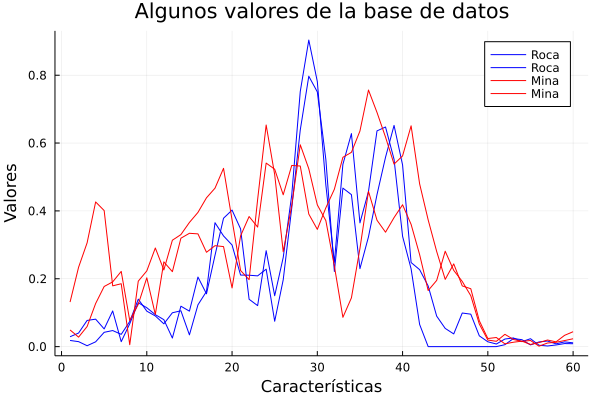

In [7]:
plot()
for i in 96:99
    if datos[i, 61] == "M"
        plot!(Array(datos[i,1:60]), color = :red, label = "Mina")#, seriestype = :scatter)
    end
    
    if datos[i, 61] == "R"
        plot!(Array(datos[i,1:60]), color = :blue, label = "Roca")#, seriestype = :scatter)
    end
end
plot!(xlabel = "Características", ylabel = "Valores", title = "Algunos valores de la base de datos")

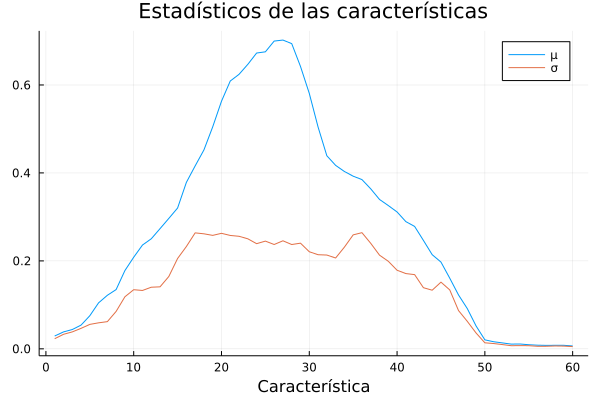

In [8]:
datos_des = describe(datos[:,1:60], :mean, :std, :min , :max)
plot(datos_des[:,2], label = "μ", xlabel = "Característica")
plot!(datos_des[:,3], label = "σ", title = "Estadísticos de las características")

Adicional observamos una gráfica que nos muestra cómo son algunos datos y el comportamiento general de estos.

## 2 Tratamos los datos

Antes de usar los datos para entrenar algunos algoritmos de *machine learning* tenemos que hacer un análisis multivariado descriptivo de los datos para poder obtener mejores resultados en la predicción.

### 2.1 Escalamos los datos

Para que no tengamos ningún problema con la escala de los datos los normalizamos o estandarizamos aunque, en este caso no hace falta pues ya se encuentran normalizados ya que son valores entre $0$ y $1$.

### 2.2 Eliminamos los datos atípicos (Outliers)

En los datos es posible encontrar datos erroneos, esto puede ser un error al momento de recolectar los datos o digitar los datos, es por eso que hace falta ver si tenemos datos atípicos que puedan afectar el aprendizaje de nuestro algoritmo y poder sacarlos. Para eliminar estas anomalías eliminaremos la filas que tengan los valores más alejados una tendencia normal de los datos, estos es, asumimos que los datos distribuyen normal y buscamos los valores extremos, luego calculamos la probabilidad de que esos extremos sean parte de los datos (que como es normal depende solo de la media y de la desviación estándar) y, de ser muy poco probables, es decir, con una probabilidad menor al 0.1% (parámetro) los eliminamos.

Ejemplificamos para el dato número 60. Vemos su gráfica:

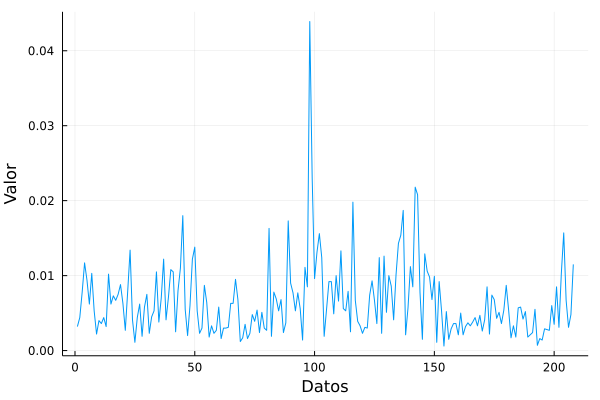

In [9]:
plot(datos[:,60], legend = false, xlabel = "Datos", ylabel = "Valor")

Podemos observar que al rededor del dato número 100 existe una anomalía lo cual podemos asumir corresponde a la captura de un dato erroneo lo cual nos gustaría eliminar. Procedemos entonces a correr una subrutina en la que por cada característica definimos la distribución normal a la cual se ajusta y verificamos si los valores extremos son improbable para clasificarlos como atípicos:

In [10]:
Out_ind = []

for i in 1:60
    X = datos[:,i]
    
    μ = mean(X)
    σ = std(X)
    Dist = Normal(μ, σ) 
    
    min, min_ind = findmin(X)
    max, max_ind = findmax(X)
    
    α = cdf(Dist, min)
    β = 1 - cdf(Dist, max)
    
    if( α < 0.001 )
        push!(Out_ind, min_ind)
    end
    
    if( β < 0.001 )
        push!(Out_ind, max_ind)
    end

end

Una vez tenemos los índices de los datos que tienen características atípicas procedemos a contarlas y con esto, eliminaremos los datos que solo presenten una o dos características atípicas puesto que el tener más de estas puede representar características importantes del dato en vez de ser un error.

In [11]:
ε = Dict(counter(Out_ind))

elim_ind = []

for (k, v) in ε
    if (v == 1 || v == 2)
        push!(elim_ind, k)
    end
end

datos = datos[Not(Array(elim_ind)),:];

El nuevo conjunto de datos sin outliars tiene entonces las siguientes características:

In [12]:
cEtiquetas = countmap(datos[:,61]) # Contamos las M's y las R's

println("La cantidad de minas es: ", cEtiquetas["M"])
println("La cantidad de rocas es: ", cEtiquetas["R"])
println("\nEl total de datos es: ", cEtiquetas["M"] + cEtiquetas["R"])

La cantidad de minas es: 100
La cantidad de rocas es: 91

El total de datos es: 191


Con lo cual eliminamos en total $13$ datos que corresponden a aquellos que tenían una característica atípica.

### 2.3 Partimos los datos entrenamiento y prueba

Fijamos un porcentaje inicial que corresponderá a la cantidad de datos que usaremos de la base de datos para el entrenamiento y, de forma aleatoria partiremos el conjunto de datos:

In [13]:
cantidadDatos = length(datos[:,1]); # Contamos la cantidad de datos

pEntrenamiento = 0.75;    # % de datos para el entrenamiento de los modelos
nEntrenamiento = convert(Integer, floor(pEntrenamiento * cantidadDatos));   # Número de datos para entrenamiento

Random.seed!(5); # Fijamos una semilla
# Creamos los indices de las filas que usaremos para los datos de entrenamiento
entrenamiento_ind = StatsBase.sample(1:cantidadDatos, nEntrenamiento, replace = false); 

entrenamiento_x = Array(datos)[entrenamiento_ind, 1:60]; # Vector de característica
entrenamiento_y = Array(datos)[entrenamiento_ind, 61]; # Vector de etiquetas

prueba_ind = setdiff(1:cantidadDatos, entrenamiento_ind); # Vemos los indices restantes

prueba_x = Array(datos)[prueba_ind, 1:60]; # Vector de característica para datos de prueba
prueba_y = Array(datos)[prueba_ind, 61]; # Vector de etiqueta para datos de prueba

En esta división de los datos obtenemos:

In [14]:
cEtiquetas_ent = countmap(entrenamiento_y) # Contamos la cantidad de R's y M's de los datos de entrenamiento
println("En los datos de entrenamiento encontramos..\n ")
println("La cantidad de minas es: ", cEtiquetas_ent["M"])
println("La cantidad de rocas es: ", cEtiquetas_ent["R"])

En los datos de entrenamiento encontramos..
 
La cantidad de minas es: 71
La cantidad de rocas es: 72


In [15]:
println("El total de datos de entrenamiento es: ", cEtiquetas_ent["M"] + cEtiquetas_ent["R"])
println("El total de datos de prueba es: ", cantidadDatos - cEtiquetas_ent["M"] - cEtiquetas_ent["R"])

El total de datos de entrenamiento es: 143
El total de datos de prueba es: 48


Creamos las variable que contengan todos los datos permutados.

In [16]:
# Hacemos el vector permutado de todos los indices de los datos
todos_ind = Vector{Int64}(shuffle([i for i in 1:cantidadDatos])) 

todos_x = Array(datos)[todos_ind, 1:60];
todos_y = Array(datos)[todos_ind, 61];

Por último dividimos los datos de entrenamiento para poder realizar luego la validación de los hiper parámetros:

In [17]:
cantidadDatos = length(entrenamiento_y); # Contamos la cantidad de datos

pEntrenamientoVal = 0.7;    # % de datos para el entrenamiento de los modelos
nEntrenamientoVal = convert(Integer, floor(pEntrenamientoVal * cantidadDatos));   # Número de datos para entrenamiento

Random.seed!(5); # Fijamos una semilla
# Creamos los indices de las filas que usaremos para los datos de entrenamiento
entrenamientoVal_ind = StatsBase.sample(1:cantidadDatos, nEntrenamientoVal, replace = false); 

entrenamientoVal_x = Array(entrenamiento_x)[entrenamientoVal_ind, 1:60]; # Vector de característica
entrenamientoVal_y = Array(entrenamiento_y)[entrenamientoVal_ind]; # Vector de etiquetas

Validacion_ind = setdiff(1:cantidadDatos, entrenamientoVal_ind); # Vemos los indices restantes

Validacion_x = Array(entrenamiento_x)[Validacion_ind, 1:60]; # Vector de característica para datos de prueba
Validacion_y = Array(entrenamiento_y)[Validacion_ind]; # Vector de etiqueta para datos de prueba

## 3 Ajustamos los modelos

Buscamos determinar los hiperparámetros adecuados con el conjunto de datos de entranamiento, para ello tenemos que definir antes una función que nos permita comparar el rendimiento de cada uno de los modelos con diferentes parámetros.

### 3.1 Definimos la metrica de rendimiento

Adicional definimos una función auxiliar que llamaremos métrica que nos permita evaluar el rendimiento de nuestoros algoritmos y poder así determinar los hiperparámetros, esta métrica es la del valor F1 que corresponde a la media armónica entre el recall y la precisión:

In [18]:
function metrica(prueba, predic) #F1
    # Esta función nos retorna la media armónica entre la exhaustividad (recall) y la precisión
    tam = length(prueba)
    VP, VN, FN, FP = 0, 0, 0, 0
    for i in 1:tam
        if( prueba[i] == predic[i] ) # Verdadero
            if( predic[i] == "M")
                VP+=1;
            else 
                VN+=1;
            end
        else                    # Falso
            if( predic[i] == "R")
                FP+=1
            else
                FN+=1
            end
        end
    end
    
    recall = VP/(VP + FN)
    precis = VP/(VP + FP)
    
    return 2/( (1/recall) + (1/precis))
    
end;

Adicional definimos una función que nos permita calcular la cantidad de acierto y el procentaje de estos:

In [19]:
function aciertos(prueba, predic)
    tam = length(prueba)
    acier = 0
    for i in 1:tam
        if( prueba[i] == predic[i] )
            acier = acier + 1
        end
    end
    return acier, acier/tam
end;

### 3.2 Ajustamos los hiperparámetros para los diferentes modelos

Ahora, implementaremos algunos métodos de la librería $\mathtt{ScikitLearn}$  y diferentes librerías para poder ajustar los datos a algunos modelos de machine learning.

In [20]:
using ScikitLearn: fit!, predict # Fit! nos servirá para ajustar los modelos y predict para predecir con ellos

### 3.2.1 Regresión lineal

En este caso el problema es de clasificación binaria, con lo cual para usar regresión lineal tenemos que ajustar los datos, más precisamente tenemos que ajustar las etiquetas pues estas son de tipo categórico y debe ser de tipo numérico y luego, las predicciones las redefinimos dado que serán valores numéricos y queremos de vuelta tipo categórico. Para hacer poder hacer lo anterior definimos unas funciones auxiliares:

In [21]:
# De letras a números
function trad_l_n( list )
    # Esta función nos permite traducir de etiquetas categoricas a numéricas
    trad = Int[]
    for i in list
        if( i == "M") # M -> 1 y R -> -1
            push!(trad, 1)
        else
            push!(trad, -1)
        end
    end
    return trad
end;

# De números a letras
function trad_n_l( list ) # Cercanos a 1 -> M y cercanos a -1 ->-1
    # Esta función nos permite traducir de etiquetas numéricas a categóricas
    trad = String[]
    for i in list
        if( i >= 0)
            push!(trad, "M")
        else
            push!(trad, "R")
        end
    end
    return trad
end;

Ahora determinamos los hiperparámetros para la regresión lineal:

In [22]:
@sk_import linear_model: LinearRegression # Importamos el modelo

Hiper_pun = []
Hiper_par = []

for i in [true, false] # fit_intercept
    for j in -5:5      # n_jobs

        lin_reg_modelo = LinearRegression(fit_intercept = i, n_jobs = j) # Inicializamos el método
        entrenamientoVal_ny = trad_l_n(entrenamientoVal_y) # Cambiamos las etiquetas de datos categóricos a numéricos
        fit!(lin_reg_modelo, entrenamientoVal_x, entrenamientoVal_ny) # Entrenamos el modelo
        lin_prediccion = predict(lin_reg_modelo, Validacion_x) # Predecimos con los datos de prueba
        lin_prediccion = trad_n_l(lin_prediccion); # Cambiamos los resultados de numérico a categóricos
        puntaje = metrica(lin_prediccion, Validacion_y)
        push!(Hiper_pun, puntaje)
        push!(Hiper_par, (i, j))

    end
end

lin_inter, lin_jobs = Hiper_par[findmax(Hiper_pun)[2]];
println("Los hiperparámetros son:\n")
println("fit_intercept = $lin_inter, n_jobs = $lin_jobs")

Los hiperparámetros son:

fit_intercept = false, n_jobs = -5


### 3.2.2 Regresión logística

Ahora implementamos el método de regresión logística

In [23]:
@sk_import linear_model: LogisticRegression

Hiper_pun = []
Hiper_par = []

for i in 0.1:0.02:3 # C

    log_reg_modelo = LogisticRegression( C = i ) # Inicializamos el método
    log_reg_modelo.max_iter = 10000 # Definimos el número máximo de iteraciones del método en 10.000
    fit!(log_reg_modelo, entrenamientoVal_x, entrenamientoVal_y) # Entrenamos el modelo
    log_prediccion = predict(log_reg_modelo, Validacion_x); # Predecimos con los datos de prueba
    puntaje = metrica(log_prediccion, Validacion_y)
    push!(Hiper_pun, puntaje)
    push!(Hiper_par, i)

end 
            
log_C = Hiper_par[findmax(Hiper_pun)[2]];
println("Los hiperparámetros son:\n")
println("C = $log_C")

Los hiperparámetros son:

C = 2.96


### 3.2.3 SVM

Ahora, para implementar la máquina de soporte vectorial vamos determinamos los hiperparámetros escogiendo los mejores resultados de acuerdo a la métrica:

In [24]:
@sk_import svm: SVC

Hiper_pun = []
Hiper_par = []

for i in 0.05:0.05:4                          # C
    for j in [:rbf, :linear, :poly, :sigmoid] # Kernel
        for k in 3:5                          # Grado
            for l in [:scale, :auto]          # Gamma

                svm = SVC( C = i , kernel = j, degree = k, gamma = l) # Inicializamos el método
                fit!(svm, entrenamientoVal_x, entrenamientoVal_y) # Entrenamos el modelo
                svm_prediccion = predict(svm, Validacion_x)
                puntaje = metrica(svm_prediccion, Validacion_y)
                push!(Hiper_pun, puntaje)
                push!(Hiper_par, (i, j, k, l))
                
            end
        end
    end
end

svm_C, svm_kernel, svm_grado, svm_gamma = Hiper_par[findmax(Hiper_pun)[2]];
println("Los hiperparámetros son:\n")
println("C = $svm_C, Kernel = $svm_kernel, Grado = $svm_grado, Γ = $svm_gamma")

Los hiperparámetros son:

C = 0.5, Kernel = poly, Grado = 4, Γ = scale


### 3.2.4 KNN

In [25]:
findmax(Hiper_pun)

(0.8484848484848485, 231)

Procedemos con el método de KNN

In [26]:
@sk_import neighbors: KNeighborsClassifier

Hiper_pun = []
Hiper_par = []

for i in 1:12                      # Vecinos
    for j in [:uniform, :distance] # Pesos
        for k in 1:10              # p de Minkowski
    
            knn_modelo = KNeighborsClassifier(n_neighbors = i, weights = j, p = k)
            knn_modelo.fit(entrenamientoVal_x, entrenamientoVal_y)
            knn_prediccion = knn_modelo.predict(Validacion_x)
            puntaje = metrica(knn_prediccion, Validacion_y)
            push!(Hiper_pun, puntaje)
            push!(Hiper_par, (i, j, k))
            
        end
    end
end

knn_vecinos, knn_pesos, knn_p = Hiper_par[findmax(Hiper_pun)[2]];
println("Los hiperparámetros son:\n")
println("Número de vecinos = $knn_vecinos, Pesos = $knn_pesos, P = $knn_p")

Los hiperparámetros son:

Número de vecinos = 1, Pesos = uniform, P = 1


### 3.2.5 Árbol de decisión

Implementamos el algoritmo del árbol de decisión:

In [27]:
@sk_import tree: DecisionTreeClassifier

Hiper_pun = []
Hiper_par = []

for i in [:gini, :entropy]     # Criterion
    for j in [:best, :random]  # Splitter
        for k in 0:0.1:5       # ccp_alpha
            
            arb_modelo = DecisionTreeClassifier( criterion = i, splitter = j, ccp_alpha = k) # Iniciamos el métodos
            fit!(arb_modelo, entrenamientoVal_x, entrenamientoVal_y) # Entrenamos el modelo
            arb_prediccion = predict(arb_modelo, Validacion_x); # Predecimos con los valores de prueba
            puntaje = metrica(arb_prediccion, Validacion_y)
            push!(Hiper_pun, puntaje)
            push!(Hiper_par, (i, j, k))
        end
    end
end

arb_criterion, arb_splitter, arb_ccp = Hiper_par[findmax(Hiper_pun)[2]];
println("Los hiperparámetros son:\n")
println("Criterio = $arb_criterion, Splitter = $arb_splitter, ccp_alpha = $arb_ccp")

Los hiperparámetros son:

Criterio = gini, Splitter = best, ccp_alpha = 0.0


## 4 Probamos los modelos

Ya una vez definidos los parámetros que usaremos entonces procedemos a predeccir los datos de prueba, pero como también nos interesa poder fuera de lo anterior ver cuál modelo se ajusta mejor vamos entonces adicionalmente vamos a implementar un proceso que se llama validación cruzada (**Cross-validation**), esta es una técnica utilizada para evaluar los resultados de un análisis estadístico y garantizar que son independientes de la partición entre datos de entrenamiento y datos de prueba, esto nos permite entonces comparar los diferentes métodos para escoger cuál de ellos es el mejor. 

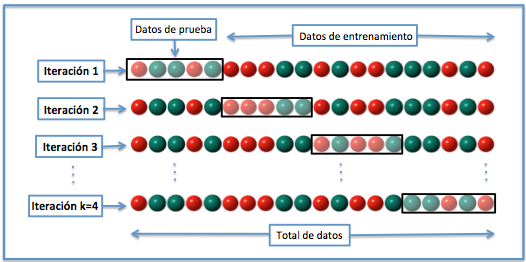

Imagen sacada de [Wikipedia](https://es.wikipedia.org/wiki/Validaci%C3%B3n_cruzada#/media/Archivo:K-fold_cross_validation.jpg).
    
En la imagen se explica cómo funciona esta técnica, en principio es partir los datos en diferentes subconjuntos y entrenar y probar con cada uno de los subconjuntos y al final tener cada uno de los errores cometidos, por lo cual es útil para estudiar el método. Usamos el siguiente método:

In [28]:
using ScikitLearn.CrossValidation: cross_val_score # Nos servirá para implementar la validación cruzada

### 4.1 Regresión lineal

In [29]:
lin_reg_modelo = LinearRegression(fit_intercept = lin_inter, n_jobs = lin_jobs) # Inicializamos el método
entrenamiento_ny = trad_l_n(entrenamiento_y) # Cambiamos las etiquetas de datos categóricos a numéricos
fit!(lin_reg_modelo, entrenamiento_x, entrenamiento_ny) # Entrenamos el modelo
lin_prediccion = predict(lin_reg_modelo, prueba_x) # Predecimos con los datos de prueba
lin_prediccion = trad_n_l(lin_prediccion); # Cambiamos los resultados de numérico a categóricos

aciertos_lin, p_aciertos_lin = aciertos(lin_prediccion, prueba_y);
lin_puntaje = metrica(lin_prediccion, prueba_y)

# Imprimimos el número de aciertos y el porcentaje de este
println("El número de aciertos es: $aciertos_lin ($(p_aciertos_lin*100) %)")
println("El puntaje obtenido por la métrica F1 es: ", lin_puntaje)

El número de aciertos es: 36 (75.0 %)
El puntaje obtenido por la métrica F1 es: 0.8125


In [30]:
vc_lin = cross_val_score(lin_reg_modelo, todos_x, trad_l_n(todos_y), cv=5); # Hacemos la validación cruzada del modelo con k = 5

media_lin = mean(vc_lin) # Hallamos la media de los resultados de la validación cruzada
desv_lin = std(vc_lin) # Hallamos la desviación estándar de los resultados de la validación cruzada

println("La puntuación media es $media_lin y la desviación estándar $desv_lin")

La puntuación media es 0.061225067942532685 y la desviación estándar 0.34850377772045305


### 4.2 Regresión logística

In [31]:
log_reg_modelo = LogisticRegression( C = log_C ) # Inicializamos el método
log_reg_modelo.max_iter = 10000 # Definimos el número máximo de iteraciones del método en 10.000
fit!(log_reg_modelo, entrenamiento_x, entrenamiento_y) # Entrenamos el modelo
log_prediccion = predict(log_reg_modelo, prueba_x); # Predecimos con los datos de prueba

aciertos_log, p_aciertos_log = aciertos(log_prediccion, prueba_y);
log_puntaje = metrica(log_prediccion, prueba_y)

# Imprimimos el número de aciertos y el porcentaje de este
println("El número de aciertos es: $aciertos_log ($(p_aciertos_log*100) %)")
println("El puntaje obtenido por la métrica F1 es: ", log_puntaje)

El número de aciertos es: 39 (81.25 %)
El puntaje obtenido por la métrica F1 es: 0.830188679245283


In [32]:
vc_log = cross_val_score(log_reg_modelo, todos_x, todos_y; cv=5); # Hacemos la validación cruzada del modelo con k = 5

media_log = mean(vc_log) # Hallamos la media de los resultados de la validación cruzada
desv_log = std(vc_log) # Hallamos la desviación estándar de los resultados de la validación cruzada

println("La puntuación media es $media_log y la desviación estándar $desv_log")

La puntuación media es 0.8118758434547908 y la desviación estándar 0.06089234224550836


### 4.3 SVM

In [33]:
svm = SVC( C = svm_C, kernel = svm_kernel, degree = svm_grado, gamma = svm_gamma) # Inicializamos el método
fit!(svm, entrenamiento_x, entrenamiento_y) # Entrenamos el modelo
svm_prediccion = predict(svm, prueba_x)

aciertos_svm, p_aciertos_svm = aciertos(svm_prediccion, prueba_y);
svm_puntaje = metrica(svm_prediccion, prueba_y);

# Imprimimos el número de aciertos y el porcentaje de este
println("El número de aciertos es: $aciertos_svm ($(p_aciertos_svm*100) %)")
println("El puntaje obtenido por la métrica F1 es: ", svm_puntaje)

El número de aciertos es: 40 (83.33333333333334 %)
El puntaje obtenido por la métrica F1 es: 0.8620689655172413


In [ ]:
vc_svm = cross_val_score(svm, todos_x, todos_y, cv=5) # Hacemos la validación cruzada del modelo con k = 5

media_svm = mean(vc_svm) # Hallamos la media de los resultados de la validación cruzada
desv_svm = std(vc_svm) # Hallamos la desviación estándar de los resultados de la validación cruzada

println("La puntuación media en validación cruzada (6) es $media_svm y la desviación estándar $desv_svm")

### 4.4 KNN

In [35]:
knn_modelo = KNeighborsClassifier(n_neighbors = knn_vecinos, weights = knn_pesos, p = knn_p)
knn_modelo.fit(entrenamiento_x, entrenamiento_y)
knn_prediccion = knn_modelo.predict(prueba_x)
puntaje = metrica(knn_prediccion, prueba_y)

aciertos_knn, p_aciertos_knn = aciertos(knn_prediccion, prueba_y);
knn_puntaje = metrica(knn_prediccion, prueba_y);

# Imprimimos el número de aciertos y el porcentaje de este
println("El número de aciertos es: $aciertos_knn ($(p_aciertos_knn*100) %)")
println("El puntaje obtenido por la métrica F1 es: ", knn_puntaje)

El número de aciertos es: 38 (79.16666666666666 %)
El puntaje obtenido por la métrica F1 es: 0.8387096774193546


In [ ]:
vc_knn = cross_val_score(knn_modelo, todos_x, todos_y, cv = 5)

media_knn = mean(vc_knn) # Hallamos la media de los resultados de la validación cruzada
desv_knn = std(vc_knn) # Hallamos la desviación estándar de los resultados de la validación cruzada

println("La puntuación media es $media_knn y la desviación estándar $desv_knn")

### 4.5 Árbol de decisión

In [37]:
arb_modelo = DecisionTreeClassifier( criterion = arb_criterion, splitter = arb_splitter, ccp_alpha = arb_ccp) # Iniciamos el métodos
fit!(arb_modelo, entrenamiento_x, entrenamiento_y) # Entrenamos el modelo
arb_prediccion = predict(arb_modelo, prueba_x); # Predecimos con los valores de prueba

aciertos_arb, p_aciertos_arb = aciertos(arb_prediccion, prueba_y);
arb_puntaje = metrica(arb_prediccion, prueba_y);

# Imprimimos el número de aciertos y el porcentaje de este
println("El número de aciertos es: $aciertos_arb ($(p_aciertos_arb*100) %)")
println("El puntaje obtenido por la métrica F1 es: ", arb_puntaje)

El número de aciertos es: 31 (64.58333333333334 %)
El puntaje obtenido por la métrica F1 es: 0.6792452830188679


In [38]:
vc_arb = cross_val_score(arb_modelo, todos_x, todos_y; cv=5); # Hacemos la validación cruzada del modelo con k = 6

media_arb = mean(vc_arb) # Hallamos la media de los resultados de la validación cruzada
desv_arb = std(vc_arb) # Hallamos la desviación estándar de los resultados de la validación cruzada

println("La puntuación media es $media_arb y la desviación estándar $desv_arb")

La puntuación media es 0.7017543859649122 y la desviación estándar 0.11637279966159297


## Conclusiones

Presentamos una tabla con un resumen de los resultados vistos anteriormente:

In [39]:
resumen = DataFrame(
    Modelos = ["Reg Lineal", "Reg Logística", "SVM", "KNN", "Árbol de decisión"], 
    F1_score = [lin_puntaje, log_puntaje, svm_puntaje, knn_puntaje, arb_puntaje],
    Aciertos = [aciertos_lin, aciertos_log, aciertos_svm, aciertos_knn, aciertos_arb],
    Porcentaje_A = [p_aciertos_lin, p_aciertos_log, p_aciertos_svm, p_aciertos_knn, p_aciertos_arb],
    Media_cv5 = [-, media_log, media_svm, media_knn, media_arb],
    Desvi_cv5 = [-, desv_log, desv_svm, desv_knn, desv_arb]
    )

resumen

,Modelos,F1_score,Aciertos,Porcentaje_A,Media_cv5,Desvi_cv5
,String,Float64,Int64,Float64,Any,Any
1,Reg Lineal,0.8125,36,0.75,-,-
2,Reg Logística,0.830189,39,0.8125,0.811876,0.0608923
3,SVM,0.862069,40,0.833333,0.812146,0.0743414
4,KNN,0.83871,38,0.791667,0.84359,0.0865257
5,Árbol de decisión,0.679245,31,0.645833,0.701754,0.116373


En lo anterior pudimos evidenciar que el modelo que mejor ajusta los datos es la máquina de soporte vectorial o *support vector machine* que en la métrica **F1** tiene la mejor puntuación con 86.2%, entre este buen rendimiento tiene también la mayor cantidad de aciertos con un 83.3%. El peor de los modelos es el árbol de decisión con un **F1-score** de 67.9% y una media de la validación cruzada de 70.1 %. Cabe resaltar que el mejor rendimiento en validación cruzada fue para el algoritmo KNN con un puntaje promedio de 84.3%.